import dependencies to be used

In [1]:
!pip install torchmetrics
import torch
print(torch.cuda.is_available())  
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import utils
from torch import optim
from torch import device
from torch import inference_mode
import tqdm
from timeit import default_timer as timer
from tqdm.auto import tqdm
from torchmetrics import ConfusionMatrix
import mlxtend
from mlxtend.plotting import plot_confusion_matrix
import numpy
from torch.utils.data import random_split

True


import data,info,evaluator

In [2]:
!pip install medmnist

import medmnist
from medmnist import INFO, Evaluator

Download data from official source

which Device to be used for training and evalution

In [3]:
# set device agnostic code
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [4]:
# download and load data from official source
data_flag = 'pathmnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# Define data transformations
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Load the full dataset
full_dataset = DataClass(split='train', transform=data_transform, download=True)

train_data = DataClass(split='train', transform=data_transform, download=True)
val_data = DataClass(split='val', transform=data_transform, download=True)
test_data = DataClass(split='test', transform=data_transform, download=True)

# Calculate split sizes
total_size = len(full_dataset)
train_size = int(0.7 * total_size)  # 70% for training
test_size = int(0.2 * total_size)   # 20% for testing
val_size = total_size - train_size - test_size  # Remaining 10% for validation

# Split the dataset into train and validation sets
#train_data, test_data, val_data = random_split(full_dataset, [train_size, test_size, val_size])

# Load the test dataset separately
#test_data = DataClass(split='test', transform=data_transform, download=True)


Using downloaded and verified file: /home/ardhendu/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/ardhendu/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/ardhendu/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/ardhendu/.medmnist/pathmnist.npz


In [5]:
train_data, test_data, val_data

(Dataset PathMNIST of size 28 (pathmnist)
     Number of datapoints: 89996
     Root location: /home/ardhendu/.medmnist
     Split: train
     Task: multi-class
     Number of channels: 3
     Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
     Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
     Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and spl

In [6]:
# check data properties
img = train_data[0][0]
label = train_data[0][1]

print(f"Image:\n {img}")
print(f"Label:\n {label}")

print(f"Image shape: {img.shape}")
print(f"Label: {label}")

Image:
 tensor([[[0.7255, 0.7176, 0.7255,  ..., 0.7255, 0.7176, 0.7333],
         [0.7098, 0.7255, 0.7176,  ..., 0.5451, 0.5059, 0.4902],
         [0.7255, 0.7255, 0.7176,  ..., 0.6314, 0.6235, 0.6392],
         ...,
         [0.7098, 0.7020, 0.7333,  ..., 0.7333, 0.7255, 0.7333],
         [0.6706, 0.7020, 0.7333,  ..., 0.7333, 0.7333, 0.7333],
         [0.6863, 0.7255, 0.7333,  ..., 0.7255, 0.7333, 0.7412]],

        [[0.6314, 0.6235, 0.6235,  ..., 0.6314, 0.6235, 0.6314],
         [0.6157, 0.6235, 0.6157,  ..., 0.3882, 0.3490, 0.3176],
         [0.6314, 0.6235, 0.6078,  ..., 0.4980, 0.5059, 0.5216],
         ...,
         [0.6078, 0.5765, 0.6314,  ..., 0.6314, 0.6314, 0.6392],
         [0.5059, 0.5686, 0.6314,  ..., 0.6314, 0.6392, 0.6314],
         [0.5294, 0.6235, 0.6314,  ..., 0.6314, 0.6314, 0.6392]],

        [[0.7804, 0.7804, 0.7804,  ..., 0.7804, 0.7804, 0.7804],
         [0.7725, 0.7725, 0.7725,  ..., 0.5843, 0.5451, 0.5294],
         [0.7725, 0.7725, 0.7647,  ..., 0.6706, 0.

In [7]:
# Number of image channels
n_channels = info['n_channels']
print(f"number of channels: {n_channels}")

# Number of classes
n_classes = len(info['label'])
print(f"number of classes: {n_classes}")

# Get the class names from the dataset
class_names = info['label']
print(f"class names: {class_names}")

number of channels: 3
number of classes: 9
class names: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6313726..0.84313726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.372549..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.32549018..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44313723..0.90588236].


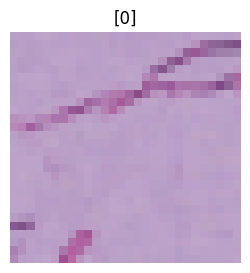

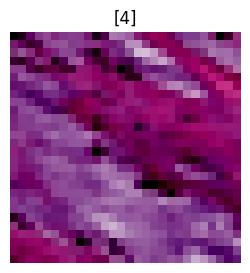

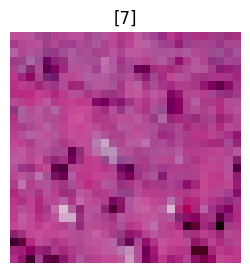

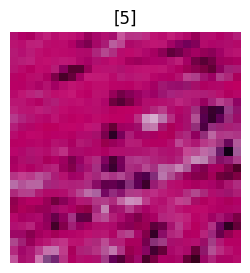

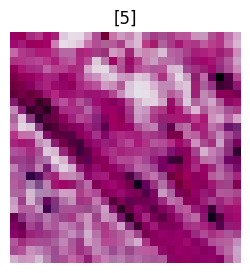

In [8]:
# check data images
for i in range(5):
    img = train_data[i][0]
    label = train_data[i][1]
    plt.figure(figsize=(3, 3))
    plt.imshow(img.permute(1, 2, 0))
    plt.title(label)
    plt.axis(False);

In [9]:
# Create DataLoaders for efficient batching
BATCH_SIZE = 64
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)


In [10]:
# check dataloader
print(f"Dataloaders: {train_dataloader, test_dataloader}") # Changed train_loader to train_dataloader and test_loader to test_dataloader
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}") # Changed train_loader to train_dataloader
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}") # Changed test_loader to test_dataloader
print(f"Length of val dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}") # Changed val_loader to val_dataloader

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f2d80bf7b20>, <torch.utils.data.dataloader.DataLoader object at 0x7f2d80bf75e0>)
Length of train dataloader: 1407 batches of 64
Length of test dataloader: 113 batches of 64
Length of val dataloader: 157 batches of 64


Get a batch from the DataLoader:

In [11]:
# Get a batch from the DataLoader:
# Split the batch into features and labels:
train_features_batch, train_labels_batch = next(iter(train_dataloader)) 
# Split the batch into features and labels:
train_features_batch, train_labels_batch = next(iter(train_dataloader)) 
#Check the shape of the features tensor:
print(train_features_batch.shape)

#shape of label
print(train_labels_batch.shape)


torch.Size([64, 3, 28, 28])
torch.Size([64, 1])


In [12]:
# define training loop functions
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):

    train_loss, train_acc = 0, 0
    model.to(device)

    for batch, (X, y) in enumerate(data_loader):
        # need to change target shape for this medmnist data
        y = y.squeeze().long()

        # Send data to selected device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. loss and accuracy
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1))

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    return train_loss, train_acc

In [13]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):

    test_loss, test_acc = 0, 0
    model.to(device)

    model.eval() # eval mode for testing
    with torch.inference_mode(): # Inference context manager
        for X, y in data_loader:
            # need to change target shape for this medmnist data
            y = y.squeeze().long()

            # Send data to selected device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                                    y_pred=test_pred.argmax(dim=1))

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

        return test_loss, test_acc

In [14]:
def eval_func(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):

    eval_loss, eval_acc = 0, 0
    model.to(device)

    model.eval()
    y_preds = []
    y_targets = []
    with torch.inference_mode():
        for batch, (X, y) in tqdm(enumerate(data_loader)):
            # need to change target shape for this medmnist data
            y = y.squeeze().long()

            # Send data to selected device
            X, y = X.to(device), y.to(device)

            # Forward pass
            eval_pred = model(X)

            # Find loss and accuracy
            eval_loss += loss_fn(eval_pred, y)
            eval_acc += accuracy_fn(y_true=y,
                                    y_pred=eval_pred.argmax(dim=1))

            # Add prediction and target labels to list
            eval_labels = torch.argmax(torch.softmax(eval_pred, dim=1), dim=1)
            y_preds.append(eval_labels)
            y_targets.append(y)

        # Scale loss and acc
        eval_loss /= len(data_loader)
        eval_acc /= len(data_loader)

        # Put predictions on CPU for evaluation
        y_preds=torch.cat(y_preds).cpu()
        y_targets=torch.cat(y_targets).cpu()

        return {"model_name": model.__class__.__name__,
                "loss": eval_loss.item(),
                "accuracy": eval_acc,
                "predictions": y_preds,
                "targets": y_targets}

In [15]:
# function to calculate model run time

def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [16]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [17]:
class cnn(torch.nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int,n_classes: int):
        super().__init__()
        self.n_classes = n_classes 
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units, 
                      kernel_size=3),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units, 
                      kernel_size=3),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, 
                         stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units*4, 
                      kernel_size=3),
            nn.BatchNorm2d(hidden_units*4),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*4, 
                      out_channels=hidden_units*4, 
                      kernel_size=3),
            nn.BatchNorm2d(hidden_units*4),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*4, 
                      out_channels=hidden_units*4, 
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(hidden_units*4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, 
                         stride=2))

        self.fc = nn.Sequential(
            nn.Linear(hidden_units*4 * 4 * 4, hidden_units*8),
            nn.ReLU(),
            nn.Linear(hidden_units*8, hidden_units*8),
            nn.ReLU(),
            nn.Linear(hidden_units*8, self.n_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    
# Define Model
model = cnn(input_shape=n_channels, 
                     hidden_units=16,
                     output_shape=n_classes,n_classes=n_classes).to(device)


# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# View Model
model

cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=

In [18]:
torch.manual_seed(42)

# Measure Time

train_time_start_model = timer()

iteration_loss_list = []
iteration_accuracy_list = []

# set parameters
epochs = 10
best_loss = 10

# call train and test function
for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(data_loader=train_dataloader,
                                       model=model,
                                       loss_fn = loss_fn,
                                       optimizer=optimizer,
                                       accuracy_fn=accuracy_fn,
                                       device=device)

    test_loss, test_acc = test_step(data_loader=test_dataloader,
                                    model=model,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn,
                                    device=device)

    for iteration, (x, y) in enumerate(train_dataloader):
        iteration_loss_list.append(train_loss.item())
        iteration_accuracy_list.append(train_acc)


    print(f"Epoch: {epoch} | Training loss: {train_loss:.3f} | Training acc: {train_acc:.2f} | Test loss: {test_loss:.3f} | Test acc: {test_acc:.2f}")

    # save best model instance

    if test_loss < best_loss:
        best_loss = test_loss
        print(f"Saving best model for epoch: {epoch}")
        torch.save(obj=model.state_dict(),
                   f="./model.pth")


train_time_end_model = timer()
total_train_time_model = print_train_time(start=train_time_start_model,
                                           end=train_time_end_model,
                                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Training loss: 0.914 | Training acc: 66.65 | Test loss: 0.987 | Test acc: 67.75
Saving best model for epoch: 0
Epoch: 1 | Training loss: 0.584 | Training acc: 78.94 | Test loss: 0.684 | Test acc: 79.43
Saving best model for epoch: 1
Epoch: 2 | Training loss: 0.424 | Training acc: 84.85 | Test loss: 0.475 | Test acc: 84.45
Saving best model for epoch: 2
Epoch: 3 | Training loss: 0.352 | Training acc: 87.29 | Test loss: 0.615 | Test acc: 79.54
Epoch: 4 | Training loss: 0.303 | Training acc: 89.10 | Test loss: 0.954 | Test acc: 78.75
Epoch: 5 | Training loss: 0.270 | Training acc: 90.31 | Test loss: 0.469 | Test acc: 85.24
Saving best model for epoch: 5
Epoch: 6 | Training loss: 0.240 | Training acc: 91.45 | Test loss: 0.621 | Test acc: 81.26
Epoch: 7 | Training loss: 0.216 | Training acc: 92.17 | Test loss: 0.571 | Test acc: 81.95
Epoch: 8 | Training loss: 0.200 | Training acc: 92.79 | Test loss: 0.684 | Test acc: 79.49
Epoch: 9 | Training loss: 0.183 | Training acc: 93.47 | T

In [20]:
# Load model
loaded_model = cnn(input_shape=n_channels,
                   hidden_units=16,
                   output_shape=n_classes,n_classes=n_classes).to(device)

loaded_model.load_state_dict(torch.load(f="./model.pth"))

# get results
model_results = eval_func(data_loader=val_dataloader,
                          model=loaded_model,
                          loss_fn=loss_fn,
                          accuracy_fn=accuracy_fn,
                          device=device)

model_results

0it [00:00, ?it/s]

{'model_name': 'cnn',
 'loss': 0.30067041516304016,
 'accuracy': 89.46656050955414,
 'predictions': tensor([5, 0, 1,  ..., 3, 0, 0]),
 'targets': tensor([5, 0, 1,  ..., 3, 0, 0])}

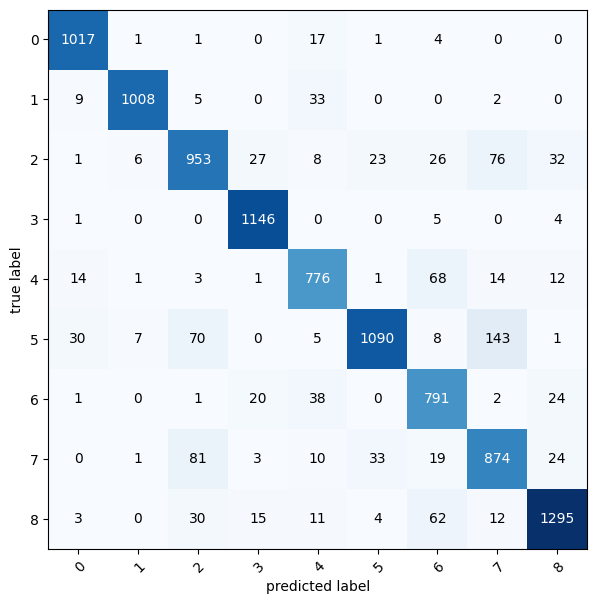

In [21]:
# Get Model predictions and true targets
y_targets = model_results['targets']
y_preds = model_results['predictions']

# Setup confusion matrix
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_preds,
                         target=y_targets)

# Plot the confusion matrix
fix, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

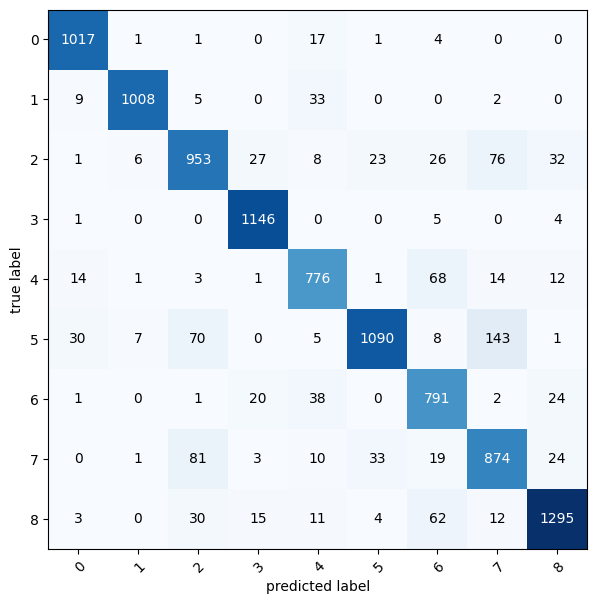

In [22]:
# Get Model predictions and true targets
y_targets = model_results['targets']
y_preds = model_results['predictions']

# Setup confusion matrix
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_preds,
                         target=y_targets)

# Plot the confusion matrix
fix, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

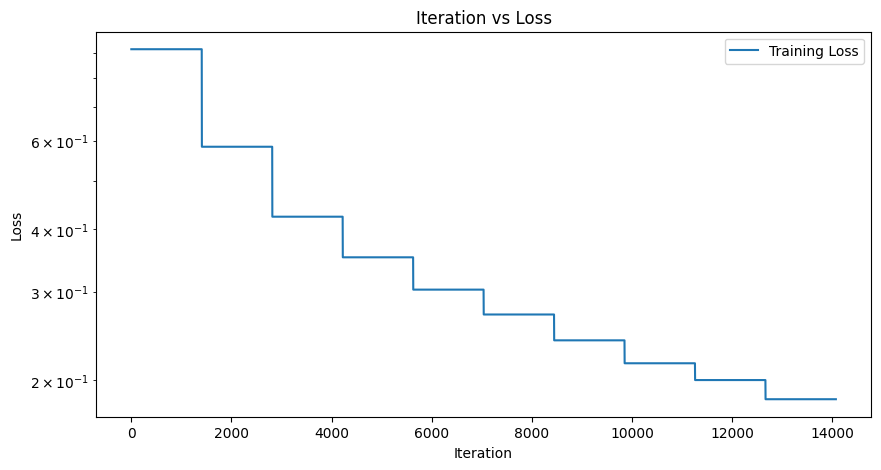

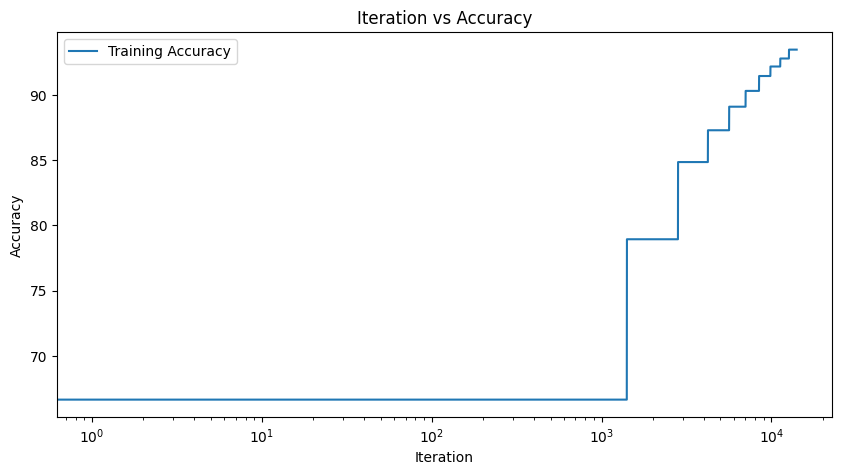

In [23]:
# Plot iteration vs loss
plt.figure(figsize=(10, 5)) 
plt.semilogy(iteration_loss_list, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Iteration vs Loss')
plt.legend()
plt.show()

# Plot iteration vs accuracy
plt.figure(figsize=(10, 5))
plt.semilogx(iteration_accuracy_list, label='Training Accuracy')  
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Iteration vs Accuracy')
plt.legend() 
plt.show()
